# Deep Q- learning Agent- Stock Trading

In this notebook, we will train an agent to trade 2 and 4 specific stocks at a time in order to maximize the profit. We will be using Deep Q-Learning.

## Getting the data from the Repo

In [1]:
!git clone https://github.com/Costopoulos/Stock-Trading-Reinforcement-Learning.git

Cloning into 'Stock-Trading-Reinforcement-Learning'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), 1000.15 KiB | 2.23 MiB/s, done.


In [2]:
%cd Stock-Trading-Reinforcement-Learning/

/kaggle/working/Stock-Trading-Reinforcement-Learning


## Imports

In [3]:
import keras
import random
import math
import gym
import sys
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from datetime import datetime, timedelta
from collections import deque

### Important Definitions
<ul> 
    <li><strong>stock1_name</strong>:   This is first stock name, is Apple - aapl.us</li>
    <li><strong>stock2_name</strong>:   This is second stock name, is Amazon - amzn.us</li>
    <li><strong>episode_count</strong>: This is number of episodes the agent will train on. In our case it's 50</li>
    <li><strong>start_balance</strong>: This is the initial budget, which is $10,000</li>
    <li><strong>training</strong>:      How many days each episode will last. Defaults at 1500</li>
    <li><strong>test</strong>:          Number of days that the test will run on. Defaults at 500 </li>
 </ul>

In [4]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

In [5]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 5 # buy_1, sell_1, do Nothing, buy2, sell2
        self.memory = deque(maxlen=2000) # deque is basically a list that provides O(1) pop & append methods
        self.inventory1 = []
        self.inventory2 = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95 # gamma is the discount factor. It quantifies how much importance we give for future rewards.
        self.epsilon = 1.0 # Exploration and Exploitation — Epsilon (ε) for ε - greedy
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model("models/" + model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon: # ε - greedy; act randomly if random returns sth < epsilon
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        minibatch = random.sample(self.memory, batch_size) # minibatch
        count = 0
    
        for state, action, reward, next_state, done in mini_batch:            
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
              
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
            count+=1

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

In [6]:
class State:
    def __init__(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        self.Stock1Price=data1[timestep] # stock 1 open price
        self.Stock2Price=data2[timestep] # stock 2 open price
        self.Stock1Blnc=Bal_stock1 # stock 1 balance
        self.Stock2Blnc=Bal_stock2 # stock 2 balance
        self.open_cash=open_cash # cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        self.portfolio_value=self.portfolio_value()

    def portfolio_value(self):
        pvalue=0

        v1=self.Stock1Price * float(self.Stock1Blnc)
        v2=self.Stock2Price * float(self.Stock2Blnc)
        v3=float(self.open_cash)
        return (v1+v2+v3)
    
    def five_day_window(self,data, timestep):
        step = timestep
        if step < 5:
            return data[0]
        
        stock_5days = np.mean(data[step-5:step])

        return stock_5days
    
    def reset(self):
        self.Stock1Price=151.25 # stock 1 open price Google
        self.Stock2Price=21.845 # stock 2 open price Walmart
        self.Stock1Blnc=34 # stock 1 balance Google
        self.Stock2Blnc=221 # stock 2 balance Walmart
        self.open_cash=10000 # cash balance
        self.fiveday_stock1=151.25
        self.fiveday_stock2=21.845
        self.portfolio_value=10000
        
    def getState(self):
        res=[]
        res.append(self.Stock1Price) # stock 1 open price
        res.append(self.Stock2Price) # stock 2 open price
        res.append(self.Stock1Blnc) # stock 1 balance
        res.append(self.Stock2Blnc) # stock 2 balance
        res.append(self.open_cash) # cash balance
        res.append(self.fiveday_stock1)
        res.append(self.fiveday_stock2)        
        res.append(self.portfolio_value)

        res1=np.array([res])
        return res1

In [7]:
stock_name1, stock_name2, episode_count, start_balance, training, test = 'googl.us', 'wm.us', 12, 10000, 1500, 500 #1500, 500

pd_data1 = pd.read_csv('data/aapl.us.txt', sep=",", header=0)
pd_data2 = pd.read_csv('data/amzn.us.txt', sep=",", header=0)

## Data Pre-processing

In this section we will do the following:
1. Look at the data of Apple and Amazon stock for checking anamolies (missing data etc.). Also convert date into right format
2. Make sure that both the stock data is for the same time period and same days in this time period. Remove data if necessary
3. Look at descriptive statistics of data- mean, median, number of records
4. Visualize the data to see how stock price changes with time
    

#### View First Stock's data

In [8]:
pd_data1.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [9]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03,8364.0
mean,22.284350,22.495867,22.054244,22.281018,1.066416e+08,0.0
std,37.763402,38.057733,37.447432,37.764469,9.935187e+07,0.0
min,0.233050,0.235640,0.230510,0.230510,0.000000e+00,0.0
25%,1.137100,1.164200,1.112800,1.137100,4.384365e+07,0.0
50%,1.632800,1.663400,1.600600,1.628250,7.481383e+07,0.0
75%,23.739000,23.930500,23.335750,23.694500,1.320534e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


#### View Second Stock's data


In [10]:
pd_data2.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [11]:
pd_data2.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.0
mean,181.747357,183.880652,179.466684,181.769343,7.837325e+06,0.0
std,239.611052,241.226109,237.638139,239.548391,7.594745e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.130000,35.000000,35.550000,3.779449e+06,0.0
50%,70.900000,72.750000,69.020000,70.700000,5.902992e+06,0.0
75%,242.850000,245.770000,240.670000,243.880000,8.888949e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


#### Drop Data that is not in both stock data- some days' data is missing in stock1 and some in stock2

In [12]:
# Convert Date to DateTime
def dateToDatetime(df1, df2):
    df1['Date'] = pd.to_datetime(df1['Date'], format='%Y/%m/%d')
    df2['Date'] = pd.to_datetime(df2['Date'], format='%Y/%m/%d')
    return df1, df2

def firstFilteringOut(df1, df2):
    if (df1['Date'][0] > df2['Date'][0]): 
        df1 = df1[df1.Date>=df2['Date'][0]]
        df1 = df1.reset_index(drop=True)
    else:
        df2 = df2[df2.Date>=df1['Date'][0]]
        df2 = df2.reset_index(drop=True)
    
    return df1, df2

# Drop columns for which data is missing in stock1 or stock2
def dropDataNotInBothStocks(df1, df2):
    df1, df2 = firstFilteringOut(df1, df2)
    list1 = df1['Date']
    list2 = df2['Date']
    diff_df1 = list(set(list1) - set(list2))
    diff_df2 = list(set(list2) - set(list1))
    
    for k in range(len(diff_df1)):
        df1_datetime_str = diff_df1[k].strftime('%Y-%m-%d 00:00:00')
        df1_datetime = datetime.strptime(df1_datetime_str, "%Y-%m-%d 00:00:00")
        for i, j in enumerate(list1):
            if j == df1_datetime:
                df1 = df1.drop([i])
    
    for k in range(len(diff_df2)):
        df2_datetime_str = diff_df2[k].strftime('%Y-%m-%d 00:00:00')
        df2_datetime = datetime.strptime(df2_datetime_str, "%Y-%m-%d 00:00:00")
        for i, j in enumerate(list2):
            if j == df2_datetime:
                df2 = df2.drop([i])
    
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    
    return df1, df2

def preprocess2Stocks(df1, df2):
    df1, df2 = dateToDatetime(df1, df2)
    df1, df2 = dropDataNotInBothStocks(df1, df2)
    return df1, df2

In [13]:
pd_data1, pd_data2 = preprocess2Stocks(pd_data1, pd_data2)

Now the data is clean, both stock1 and stock2 have 5151 records

In [14]:
pd_data1['Date'][0]

Timestamp('1997-05-16 00:00:00')

In [15]:
pd_data2['Date'][0]

Timestamp('1997-05-16 00:00:00')

In [16]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.0
mean,35.484689,35.816124,35.123519,35.479585,1.367661e+08,0.0
std,43.150378,43.473086,42.805762,43.153299,1.119530e+08,0.0
min,0.412350,0.423880,0.408530,0.413660,0.000000e+00,0.0
25%,1.518700,1.552100,1.488200,1.521300,6.327315e+07,0.0
50%,12.362000,12.710000,12.060000,12.403000,1.075093e+08,0.0
75%,64.097000,64.834000,63.631500,64.308500,1.764941e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


In [17]:
pd_data2.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.0
mean,181.812687,183.946772,179.531361,181.834821,7.835138e+06,0.0
std,239.634626,241.249596,237.661600,239.571842,7.594587e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.230000,35.010000,35.580000,3.777334e+06,0.0
50%,70.940000,72.810000,69.020000,70.730000,5.901100e+06,0.0
75%,243.035000,246.240000,241.015000,243.900000,8.888874e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


### Data Visualization

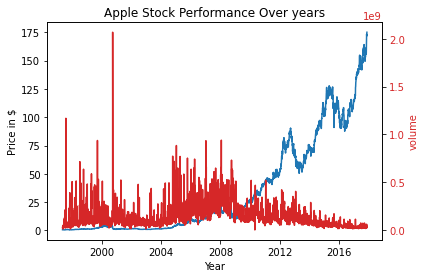

In [18]:
# Stock1 Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

x1 = np.array(pd_data1['Date'])
y1 = pd_data1['Open']
y12= pd_data1['Volume']

plt.title("Apple Stock Performance Over years")
plt.xlabel("Year")
plt.ylabel("Price in $")
plt.plot(x1,y1)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x1, y12, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

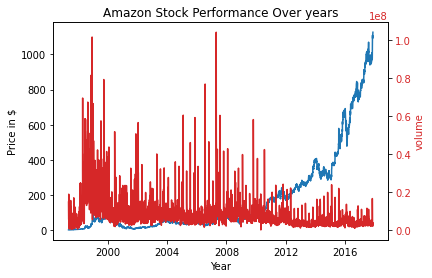

In [19]:
# Stock2 Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

x2 = np.array(pd_data2['Date'])
y2 = pd_data2['Open']
y22= pd_data2['Volume']


plt.title("Amazon Stock Performance Over years")
plt.xlabel("Year")
plt.ylabel("Price in $")

plt.plot(x2,y2)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, y22, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

## Split Training and Test data

Next step is to divide data into training and test set. This has to be done in a chronological order. So, data is divided into:
- training set from days 0 to days 'training'
- test set: from days 'training' to day 'training+ test'

In [20]:
def train_test_split(df, train_size, test_size):
    df_train = df[0:train_size]
    df_test = df[train_size:train_size+test_size]
    
    return df_train, df_test

In [21]:
# Split
pd_data1_train, pd_data1_test = train_test_split(pd_data1, training, test)
pd_data2_train, pd_data2_test = train_test_split(pd_data2, training, test)

Make the pd_data'INDEX'_test variables act like lists (have numerical indexes)

In [22]:
pd_data1_test = pd_data1_test.reset_index(drop=True)
pd_data2_test = pd_data2_test.reset_index(drop=True)

## Initialize state and set benchmarking model

In [23]:
def benchmark(df1, df2, train_size, initial_balance, test=False):
    """
    df1, df2: The stocks
    train_size: The size (days) of the training
    initial_balance: The starting wallet balance
    """
    data1 = df1['Open']
    data2 = df2['Open']
    
    data1Date = df1['Date']
    
    benchStock1Balance = int(np.floor((initial_balance/4)/data1[0]))
    benchStock2Balance = int(np.floor((initial_balance/4)/data2[0]))
    openCash = initial_balance/2
    
    # sell 10% of stock in 10 intervals
    interval = int(train_size/10)
    
    stock1Balance = np.floor(benchStock1Balance/10)
    stock2Balance = np.floor(benchStock2Balance/10)
    
    benchmarkValue = []
    
    for i in range(interval, train_size+1, interval):
        closingStock1Price = data1[i-1]
        closingStock2Price = data2[i-1]

        stock1Date = data1Date[i-1].strftime('%Y-%m-%d')

        stocks1Value = stock1Balance * closingStock1Price
        stocks2Value = stock2Balance * closingStock2Price
        
        benchStock1Balance -= stock1Balance
        benchStock2Balance -= stock2Balance

        stock1PortValue = benchStock1Balance * closingStock1Price
        stock2PortValue = benchStock2Balance * closingStock2Price
        
        openCash += stocks1Value + stocks2Value #Adding 10% sold value into open cash

        totalPortfolioValue = openCash + stock1PortValue + stock2PortValue
        benchmarkValue.append([stock1Date, benchStock1Balance, benchStock2Balance, totalPortfolioValue])
    
    return data1, data2, benchmarkValue

In [24]:
data1_train, data2_train, benchValue = benchmark(pd_data1_train, pd_data2_train, training, start_balance)
print(f'Benchmark Profit is {benchValue[-1][3]} with Stock1: {benchValue[-1][1]} and Stock2: {benchValue[-1][2]}')

Benchmark Profit is 52655.372749999995 with Stock1: 6.0 and Stock2: 9.0


## Training

In [25]:
def qLearningTrading(df1, df2, train_size, initial_balance, batch_size):
    """
    df1, df2: The train or the test data of each stock
    train_size: The size (days) of the training
    initial_balance: The starting wallet balance
    batch_size: The size used for the agent's experience replay method
    """
    # Define arrays to store per episode values 
    total_Prof = []
    total_stock1bal = []
    total_stock2bal = []
    total_open_cash = []
    total_port_value = []
    total_days_played = []
    
    for e in range(episode_count + 1):
        print("..........")
        print(f"Episode {e}/{episode_count}")

        benchStock1Balance = int(np.floor((initial_balance/4)/df1[0]))
        benchStock2Balance = int(np.floor((initial_balance/4)/df2[0]))
        openCash = initial_balance/2

        done = False
        total_profit = 0
        reward = 0

        # Initialize Agent
        agent = Agent(8)
        agent.inventory1 = []
        agent.inventory2 = []
        for i in range(benchStock1Balance):
            agent.inventory1.append(df1[0])
        for i in range(benchStock2Balance):
            agent.inventory2.append(df2[0]) 


        # Running episode over all days in the train_size
        for t in range(train_size):
            stateClassObj = State(df1, df2, benchStock1Balance, benchStock2Balance, openCash, t)
            stateArrayObj = stateClassObj.getState()
            action = agent.act(stateArrayObj)

            changePercentStock1 = (stateClassObj.Stock1Price - stateClassObj.fiveday_stock1) / stateClassObj.fiveday_stock1 * 100
            changePercentStock2 = (stateClassObj.Stock2Price - stateClassObj.fiveday_stock2) / stateClassObj.fiveday_stock2 * 100

            if action == 0:  # Buy stock 1
                if stateClassObj.Stock1Price > stateClassObj.open_cash:
    #                 print("Bought stock 1 when agent did not have money. File for bankruptcy and end of episode")
                    reward = -200000
                    done = True # end of episode

                else:
                    agent.inventory1.append(df1[t])
                    stock1Balance = len(agent.inventory1)
                    stock2Balance = len(agent.inventory2)
                    cash = stateClassObj.open_cash - stateClassObj.Stock1Price # Buy 1 stock

                    if(stateClassObj.open_cash < 500):
                        reward = -100000
                    elif (abs(changePercentStock1) <= 2):
                        reward = -10000
                    else:  
                        reward = -changePercentStock1 * 100

            if action == 1:  # Sell stock 1
                if stateClassObj.Stock1Blnc < 1:# or len(agent.inventory1) < 1:
    #                 print("Sold stock 1 when agent did not have any stock1. File for bankruptcy and end of episode")
                    reward = -200000
                    done = True # end of episode

                else:
                    boughtPrice1 = agent.inventory1.pop(0)
                    stock1Balance = len(agent.inventory1)
                    stock2Balance = len(agent.inventory2)
                    cash = stateClassObj.open_cash + stateClassObj.Stock1Price # Sell 1 stock

                    if (stateClassObj.Stock1Blnc < 10):
                        reward = -100000
                    elif (abs(changePercentStock1) <= 2):
                        reward = -10000
                    else:
                        reward = changePercentStock1 * 100
                        
#                     total_profit += stateClassObj.Stock1Price - boughtPrice1
                    
            if action == 2: # Do nothing action    
                if (abs(changePercentStock1) <= 2) and (abs(changePercentStock2) <= 2):
                    reward = 10000
                elif (stateClassObj.open_cash < 0.1 * initial_balance):
                    reward = 1000000
                elif (abs(changePercentStock1) <= 2) or (abs(changePercentStock2) <= 2):
                    reward = 1000
                else:
                    reward = -100000

                stock1Balance = len(agent.inventory1)
                stock2Balance = len(agent.inventory2)
                cash = openCash


            if action == 3:  # Buy stock 2
                if stateClassObj.Stock2Price > stateClassObj.open_cash:
    #                 print("Bought stock 2 when agent did not have money. File for bankruptcy and end of episode")
                    reward = -200000
                    done = True

                else:
                    agent.inventory2.append(df2[t])
                    stock1Balance = len(agent.inventory1)
                    stock2Balance = len(agent.inventory2)
                    cash = stateClassObj.open_cash - stateClassObj.Stock2Price

                    if (stateClassObj.open_cash < 5000):
                        reward = -100000
                    elif (abs(changePercentStock2) <= 2):
                        reward = -10000
                    else:
                        reward = -changePercentStock2 * 100


            if action == 4:  # Sell stock 2
                if stateClassObj.Stock2Blnc < 1:# or len(agent.inventory2) < 1:
    #                 print("Sold stock 2 when agent did not have any stock2. File for bankruptcy and end of episode")
                    reward = -200000
                    done = True
                else:
                    boughtPrice2 = agent.inventory2.pop(0)
                    stock1Balance = len(agent.inventory1)
                    stock2Balance = len(agent.inventory2)
                    cash = stateClassObj.open_cash + stateClassObj.Stock2Price # Sell 1 stock

                    if (stateClassObj.Stock2Blnc < 10):
                        reward = -100000
                    elif (abs(changePercentStock2) <= 2):
                        reward = -10000
                    else:
                        reward = changePercentStock2 * 100 

#                     total_profit += stateClassObj.Stock2Price - boughtPrice2

            if t == train_size - 1:
                done = True
                nextStateClassObj = State(df1, df2, stock1Balance, stock2Balance, cash, t)
                nextStateArrayObj = nextStateClassObj.getState()
            else:
                nextStateClassObj = State(df1, df2, stock1Balance, stock2Balance, cash, t + 1)
                nextStateArrayObj = nextStateClassObj.getState()

            agent.memory.append((stateClassObj, action, reward, nextStateArrayObj, done))

            benchStock1Balance = stock1Balance
            benchStock2Balance = stock2Balance
            openCash = cash

            if done == True:
                total_Prof.append(nextStateClassObj.portfolio_value - initial_balance)
                total_stock1bal.append(len(agent.inventory1))
                total_stock2bal.append(len(agent.inventory2))
                total_open_cash.append(stateClassObj.open_cash)
                total_port_value.append(stateClassObj.portfolio_value)
                total_days_played.append(t)

                print("--------------------------------")
                stateClassObj.reset()
                break

            if len(agent.memory) > batch_size:
                agent.expReplay(batch_size)

        if e % 10 == 0:
            agent.model.save("models/model_ep" + str(e))

    return total_Prof, total_stock1bal, total_stock2bal, total_open_cash, total_port_value, total_days_played, agent

In [26]:
total_Prof, total_stock1bal, total_stock2bal, total_open_cash, total_port_value, total_days_played, agent_train = qLearningTrading(data1_train, data2_train, training, start_balance, 64)

print(f"Total Apple stocks in episodes: {total_stock1bal}")
print(f"Total Amazon stocks in episodes: {total_stock2bal}")
print(f"Total Open cash in episodes: {total_open_cash}")
print(f"Total Portfolio value in episodes: {total_port_value}")
print(f"Total Days in episodes: {total_days_played}")
print(f"Total Profit in episodes: {total_Prof}")

print(f'Benchmark Profit is {benchValue[-1][3]} with Stock1: {benchValue[-1][1]} and Stock2: {benchValue[-1][2]}')

..........
Episode 0/12


2022-03-16 15:25:57.314250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:25:57.410543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:25:57.411799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 15:25:57.414179: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

--------------------------------


2022-03-16 15:26:42.905493: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


..........
Episode 1/12
--------------------------------
..........
Episode 2/12
--------------------------------
..........
Episode 3/12
--------------------------------
..........
Episode 4/12
--------------------------------
..........
Episode 5/12
--------------------------------
..........
Episode 6/12
--------------------------------
..........
Episode 7/12
--------------------------------
..........
Episode 8/12
--------------------------------
..........
Episode 9/12
--------------------------------
..........
Episode 10/12
--------------------------------
..........
Episode 11/12
--------------------------------
..........
Episode 12/12
--------------------------------
Total Apple stocks in episodes: [5697, 4472, 5652, 5707, 4452, 4468, 5692, 5690, 4435, 4458, 4450, 5701, 5684]
Total Amazon stocks in episodes: [1281, 1288, 1245, 1274, 1268, 1112, 1249, 1276, 35, 1484, 1452, 1252, 1263]
Total Open cash in episodes: [2729.5491300000035, 5157.093600000003, 2785.1397299999967, 270

## Benchmark model for Actual Test Run

In [27]:
data1_test, data2_test, benchValueTest = benchmark(pd_data1_test, pd_data2_test, test, start_balance)
print(f'Benchmark Profit is {benchValueTest[-1][3]} with Stock1: {benchValueTest[-1][1]} and Stock2: {benchValueTest[-1][2]}')

Benchmark Profit is 13725.190299999998 with Stock1: 9.0 and Stock2: 6.0


## Test

In [28]:
def qLearningTradingTest(df1, df2, train_size, initial_balance, model_name, agent_train):
    """
    df1, df2: The test data of each stock
    train_size: The size (days) of the training
    initial_balance: The starting wallet balance
    model_name: The name of the model we will load
    """
    # Define arrays to store per episode values 
    Act_total_Prof = []
    Act_total_stock1bal = []
    Act_total_stock2bal = []
    Act_total_open_cash = []
    Act_total_port_value = []
    Act_total_days_played = []
    actions_done_perday = []
    portfolio_value = []
    
    model = load_model("models/" + model_name)
    
    benchStock1Balance = int(np.floor((initial_balance/4)/df1[0]))
    benchStock2Balance = int(np.floor((initial_balance/4)/df2[0]))
    openCash = initial_balance/2

    done = False
    total_profit = 0
    reward = 0
    days_count = 0

    # Initialize Agent
    agent = Agent(8, is_eval=True, model_name=model_name)
    agent.inventory1 = []
    agent.inventory2 = []
    for i in range(benchStock1Balance):
        agent.inventory1.append(df1[0])
    for i in range(benchStock2Balance):
        agent.inventory2.append(df2[0])

    cash = openCash
    # Running episode over all days in the train_size
    for t in range(train_size):
        print("..........")
        
        print(pd_data1_test.iloc[t,0])
       
        stateClassObj = State(df1, df2, benchStock1Balance, benchStock2Balance, cash, t)
        stateArrayObj = stateClassObj.getState()
        action = agent.act(stateArrayObj)
        
        print(f"Total portfolio value: {stateClassObj.portfolio_value}, stock1 number: {len(agent.inventory1)}, "
              + f"stock2 number: {len(agent.inventory2)} and open cash: {stateClassObj.open_cash}")

        changePercentStock1 = (stateClassObj.Stock1Price - stateClassObj.fiveday_stock1) / stateClassObj.fiveday_stock1 * 100
        changePercentStock2 = (stateClassObj.Stock2Price - stateClassObj.fiveday_stock2) / stateClassObj.fiveday_stock2 * 100
        
        if action == 0:  # Buy stock 1
            if stateClassObj.Stock1Price > stateClassObj.open_cash:
                done = True # end of episode; not enough money to buy

            else:
                agent.inventory1.append(df1[t])
                stock1Balance = len(agent.inventory1)
                stock2Balance = len(agent.inventory2)
                cash = stateClassObj.open_cash - stateClassObj.Stock1Price # Buy 1 stock

        if action == 1:  # Sell stock 1
            if stateClassObj.Stock1Blnc < 1:# or len(agent.inventory1) < 1:
                done = True # end of episode

            else:
                agent.inventory1.pop(0)
                stock1Balance = len(agent.inventory1)
                stock2Balance = len(agent.inventory2)
                cash = stateClassObj.open_cash + stateClassObj.Stock1Price # Sell 1 stock


        if action == 2: # Do nothing action    
            stock1Balance = len(agent.inventory1)
            stock2Balance = len(agent.inventory2)

        if action == 3:  # Buy stock 2
            if stateClassObj.Stock2Price > stateClassObj.open_cash:
                done = True
                
            else:
                agent.inventory2.append(df2[t])
                stock1Balance = len(agent.inventory1)
                stock2Balance = len(agent.inventory2)
                cash = stateClassObj.open_cash - stateClassObj.Stock2Price # Sell 1 stock


        if action == 4:  # Sell stock 2
            if stateClassObj.Stock2Blnc < 1:# or len(agent.inventory2) < 1:
                done = True # don't have stock2.
                
            else:
#                 try:
#                     agent.inventory2.pop(0)
#                 except:
#                     agent_train.inventory2.pop(0)
#                 agent_train.inventory2.pop(0)
                agent.inventory2.pop(0)
                stock1Balance = len(agent.inventory1)
                stock2Balance = len(agent.inventory2)
                cash = stateClassObj.open_cash + stateClassObj.Stock2Price # Sell 1 stock

        if t == train_size - 1:
            done = True
            nextStateClassObj = State(df1, df2, stock1Balance, stock2Balance, cash, t)
            nextStateArrayObj = nextStateClassObj.getState()
        else:
            nextStateClassObj = State(df1, df2, stock1Balance, stock2Balance, cash, t + 1)
            nextStateArrayObj = nextStateClassObj.getState()

        actions_done_perday.append(action)
        portfolio_value.append(nextStateClassObj.portfolio_value)
        
#         benchStock1Balance = stock1Balance
#         benchStock2Balance = stock2Balance
#         openCash = cash
        
        if action != 2:
            days_count += 1

        if done == True:
            print("--------------------------------")
            print(f"Total Profit: {formatPrice(stateClassObj.portfolio_value - initial_balance)}")
            print(f"Total No. of days played: {days_count} out of overall days: {train_size}")
            print(f"Total portfolio value: {stateClassObj.portfolio_value}, stock1 number: {len(agent.inventory1)}, "
              + f"stock2 number: {len(agent.inventory2)} and open cash: {nextStateClassObj.open_cash}")

            print("--------------------------------")
            stateClassObj.reset()
            break
            
        

    return portfolio_value

In [29]:
portfolio_value = qLearningTradingTest(data1_test, data2_test, test, start_balance, 'model_ep10', agent_train) #'model_ep10'

..........
2003-05-15 00:00:00
Total portfolio value: 9980.548999999999, stock1 number: 2099, stock2 number: 76 and open cash: 5000.0
..........
2003-05-16 00:00:00
Total portfolio value: 9935.5102, stock1 number: 2099, stock2 number: 77 and open cash: 4967.36
..........
2003-05-19 00:00:00
Total portfolio value: 9911.7729, stock1 number: 2099, stock2 number: 78 and open cash: 4934.849999999999
..........
2003-05-20 00:00:00
Total portfolio value: 9733.2411, stock1 number: 2099, stock2 number: 79 and open cash: 4902.15
..........
2003-05-21 00:00:00
Total portfolio value: 9652.781500000001, stock1 number: 2099, stock2 number: 80 and open cash: 4870.589999999999
..........
2003-05-22 00:00:00
Total portfolio value: 9657.9838, stock1 number: 2099, stock2 number: 81 and open cash: 4839.11
..........
2003-05-23 00:00:00
Total portfolio value: 9766.543300000001, stock1 number: 2099, stock2 number: 82 and open cash: 4807.36
..........
2003-05-27 00:00:00
Total portfolio value: 9662.1899, sto

## Plot Portfolio Value after 1) Training and Testing vs 2) Benchmarking over Test Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.


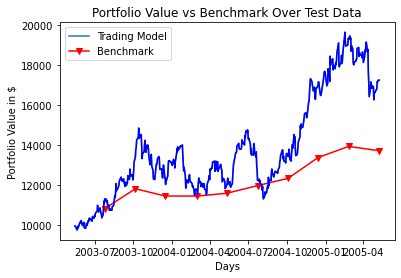

In [30]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(benchValueTest) #Benchmark_Port_Value
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(pd_data1_test['Date'])
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[3] #TotalPortfolioValue (pd_bm[1] in the old version)



plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value in $")

plt.plot(x1,y1)
plt.plot_date(x2, y2, c = 'red', marker='v', linestyle='-')


#plt.plot(x1, z, '-', color='black');
plt.plot(x1, y1, '-', color='blue');



#plt.scatter(x1,Benchmark_Port_Value,marker='o')

plt.legend(('Trading Model', 'Benchmark'))

plt.show()